In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
project_path = '/content/drive/My Drive/ds_harsh_singh'
os.chdir(project_path)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid")
trader_file = 'historical_data.csv'
sentiment_file = 'fear_greed_index.csv'

In [28]:
trader_df = pd.read_csv(f'csv_files/{trader_file}')
sentiment_df = pd.read_csv(f'csv_files/{sentiment_file}')
print("✅ Datasets loaded successfully!")

✅ Datasets loaded successfully!


In [6]:
print(trader_df.head())
trader_df.describe()
trader_df.info()

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [7]:
print(trader_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [37]:
trader_df['is_profit']=(trader_df['Closed PnL']>0).astype(int)

In [35]:
trader_df['time']= pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")
trader_df['date']= trader_df['time'].dt.date

In [16]:
print(sentiment_df.head())
print(sentiment_df.describe())
print(sentiment_df.columns)

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
          timestamp        value
count  2.644000e+03  2644.000000
mean   1.631899e+09    46.981089
std    6.597967e+07    21.827680
min    1.517463e+09     5.000000
25%    1.574811e+09    28.000000
50%    1.631900e+09    46.000000
75%    1.688989e+09    66.000000
max    1.746164e+09    95.000000
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [29]:
sentiment_df['sentiment_simple'] = sentiment_df['classification'].apply(
    lambda x: 'Fear' if 'Fear' in str(x) else ('Greed' if 'Greed' in  str(x)else 'Neutral')
)

In [30]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['date'] = sentiment_df['date'].dt.date

In [32]:
sentiment_df_clean = sentiment_df[['date','sentiment_simple']]

In [33]:
print(sentiment_df_clean.head())

         date sentiment_simple
0  2018-02-01             Fear
1  2018-02-02             Fear
2  2018-02-03             Fear
3  2018-02-04             Fear
4  2018-02-05             Fear


In [38]:
# aggregating trader data day  by  day
daily_trader_stats = trader_df.groupby('date').agg(
    total_volume_usd = ('Size USD','sum'),
    total_PnL=('Closed PnL','sum'),
    win_rate=('is_profit','mean')
).reset_index()

In [40]:
# merging the both dataset
merged_df = pd.merge(
    daily_trader_stats,
    sentiment_df_clean,
    on='date',
    how='inner'
)

In [44]:
merged_df = merged_df[merged_df['sentiment_simple'] != 'Neutral']
print(merged_df.head())

         date  total_volume_usd   total_PnL  win_rate sentiment_simple
0  2023-05-01            477.00    0.000000  0.000000            Greed
1  2023-12-05          50005.83    0.000000  0.000000            Greed
2  2023-12-14         113203.35 -205.434737  0.363636            Greed
3  2023-12-15          10609.95  -24.632034  0.000000            Greed
4  2023-12-16          15348.77    0.000000  0.000000            Greed


now analysis and visualization  **part**

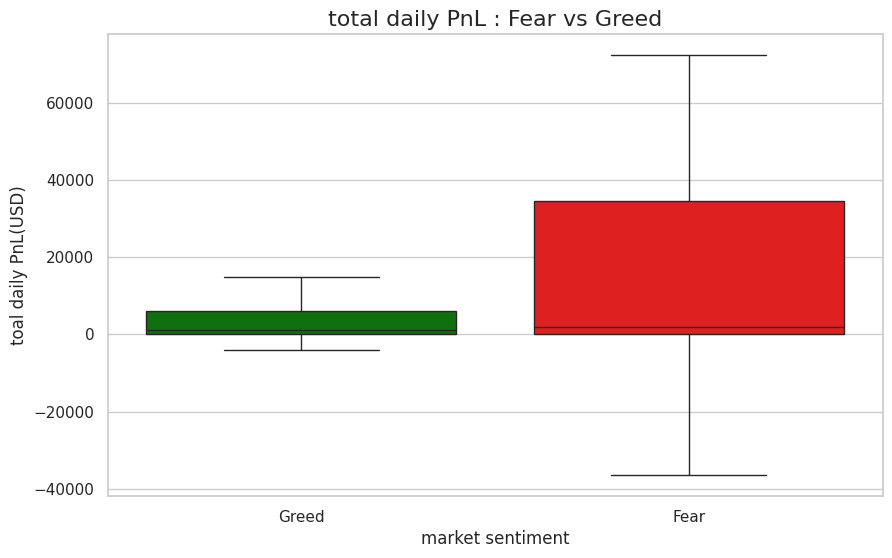

In [47]:
import os

# analysis is done after understanding the metrics of trading how and what to compare doamin knowldege was studied before the coding part
plt.figure(figsize=(10,6))

sns.boxplot(data=merged_df, x='sentiment_simple', y = 'total_PnL', hue='sentiment_simple', palette={'Fear':'red','Greed':'green'}, showfliers=False, legend=False)
plt.title('total daily PnL : Fear vs Greed',fontsize=16)
plt.xlabel('market sentiment')
plt.ylabel('toal daily PnL(USD)')

if not os.path.exists('outputs'):
    os.makedirs('outputs')

plt.savefig('outputs/1_pnl_vs_sentiment.png')
plt.show()

/tmp/ipython-input-722299610.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_df, x='sentiment_simple', y = 'win_rate', palette={'Fear':'red', 'Greed':'green'})


Text(0, 0.5, 'Average Win Rate (%)')

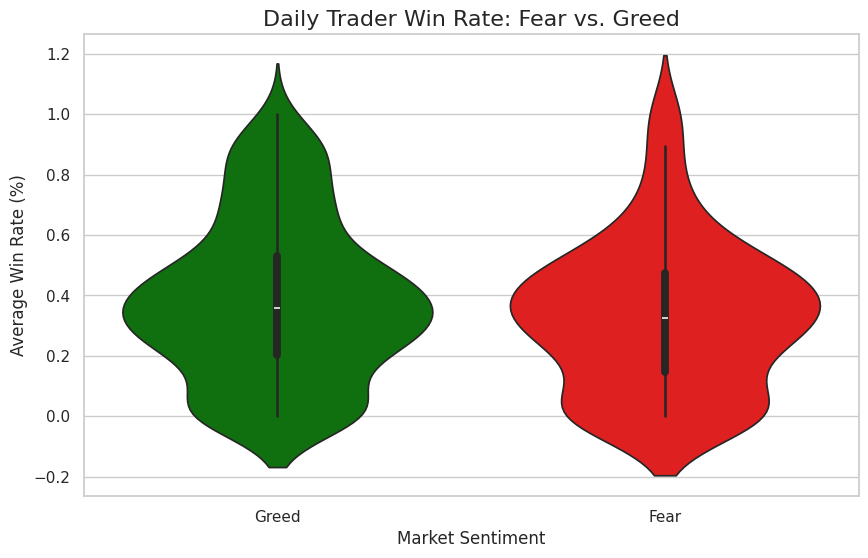

In [48]:
# second plot is trader success win rate vs sentiment
plt.figure(figsize=(10,6))

sns.violinplot(data=merged_df, x='sentiment_simple', y = 'win_rate', palette={'Fear':'red', 'Greed':'green'})
plt.title('Daily Trader Win Rate: Fear vs. Greed', fontsize=16)
plt.xlabel('Market Sentiment')
plt.ylabel('Average Win Rate (%)')

In [49]:
plt.savefig('outputs/2_winrate_vs_sentiment.png')
plt.show()

<Figure size 640x480 with 0 Axes>

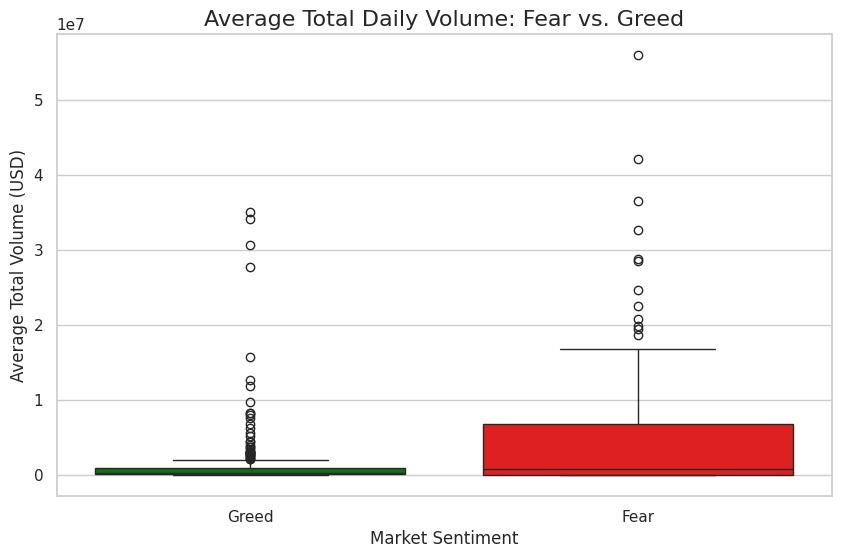

<Figure size 640x480 with 0 Axes>

In [53]:
# market activity(volume) vs sentiment--
plt.figure(figsize=(10,6))

sns.boxplot(data=merged_df, x='sentiment_simple', y = 'total_volume_usd', hue='sentiment_simple', palette={'Fear':'red', 'Greed':'green'}, legend=False)
plt.title('Average Total Daily Volume: Fear vs. Greed', fontsize=16)
plt.xlabel('Market Sentiment')
plt.ylabel('Average Total Volume (USD)')
plt.show()
plt.savefig('outputs/3_volume_vs_sentiment.png')